In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from svmc import SVMCTF, Model, QPU, load_dwave_schedule, theta_to_spins
from dimod import BQM

### QPU setup
See https://docs.dwavesys.com/docs/latest/doc_physical_properties.html for schedules and other properties.

In [2]:
s, A, B = load_dwave_schedule("09-1263A-A_Advantage_system4_1_annealing_schedule.xlsx")
temperature = 15.4
h_range = [-4.0, 4.0]
J_range = [-1.0, 1.0]
qpu = QPU(s, A, B, temperature, h_range, J_range)

### Generate a random Sherrington-Kirkpatrick model

In [3]:
n = 8
h = np.random.rand(n)
J = np.triu(np.random.rand(n), k=1)
bqm = BQM.from_ising(h, J)
model = Model(bqm, qpu)

### Get schedule for SVMCTF

In [4]:
annealing_sweeps = 1_000
sweep_schedule = qpu.get_sweep_schedule(annealing_sweeps)

### Sample with SVMCTF

In [5]:
svmc = SVMCTF(qpu, model)
angles = svmc.sample(sweep_schedule)
spins = theta_to_spins(angles)
print("spins", spins)
print("energy", bqm.energy(spins))

spins [-1 -1  1  1 -1  1 -1 -1]
energy -2.8919005393703623


### Sample with a pause

In [6]:
annealing_sweeps = 1_000
pause_sweeps = 1_000
pause_location = 0.4
sweep_schedule = qpu.get_sweep_schedule(annealing_sweeps, pause_sweeps, pause_location)
svmc = SVMCTF(qpu, model)
angles = svmc.sample(sweep_schedule)
spins = theta_to_spins(angles)
print("spins", spins)
print("energy", bqm.energy(spins))

spins [-1 -1  1  1 -1  1  1 -1]
energy -4.1528088655774456


### Vary pause location

In [7]:
# may take a while
annealing_sweeps = 1_000
pause_sweeps = 1_000
repeats = 500
pause_locations = np.arange(0.2, 0.8, 0.05)
mean_energies = []
for pause_location in pause_locations:
    sweep_schedule = qpu.get_sweep_schedule(annealing_sweeps, pause_sweeps, pause_location)
    total_energy = 0
    for i in range(repeats):
        angles = svmc.sample(sweep_schedule)
        spins = theta_to_spins(angles)
        total_energy += bqm.energy(spins)
    mean_energies.append(total_energy/repeats)

Text(0.5, 0, 's')

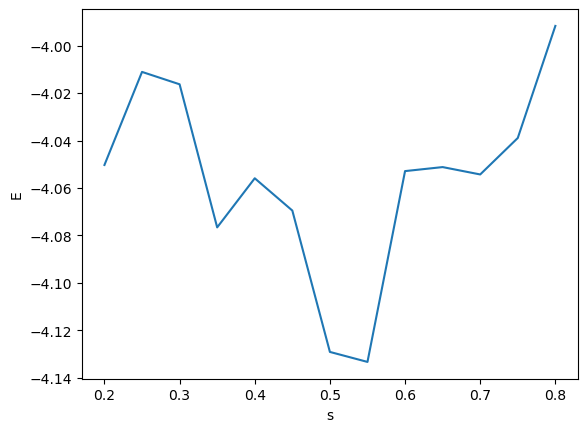

In [8]:
plt.plot(pause_locations, mean_energies)
plt.ylabel("E")
plt.xlabel("s")